# Introduction to Auto-Encoders
In this notebook, we explore a more complex architecture, famous to be able to generate new images from random samples: the `AutoEncoder` (AE).

The idea is to build two Convolutional Networks (CNNs), an `Encoder` E and a `Decoder` D. The Encoder takes an image X as input and will perform a compression/encoding in a (much) smaller space called `Latent Space`. We will call `z` the code or encoding of the image, `E(X)=z`. The decoer will then take `z` as an input and try to `decode` it to recreate the input image `X`, `D(z)=X'`. 

The loss is a simple pixel-wise Mean Square Error between the reconstructed image X' and X. It's a great example of an unsupervised model: we don't need any label/ extra knowledge about our data, because the loss is directly computed on the input (that's why it is called `Auto`Encoder)

When trained, the AE is very usefull for two things:
- By sampling new codes `z'` from the latent space, we can feed them to the decoder to create new images !
- Because the Decoder only knows about z to recreate the image, it means that the latent space and codes are a very good compression of the dataset: exploring it, with clustering, outlier detection, or using it to plug other models will be a very powerful way to better understand you data.

### So let's go threw it !

In [1]:
import tensorflow as tf
from tensorflow import keras as tfk  
import tensorflow_datasets as tfdatasets
import numpy as np
import matplotlib.pyplot as plt
tfkl = tfk.layers

## Loading data and creating an Input Pipeline
We will be working with the MNIST dataset, a famous dataset of hand-written digits, often called the "Hello Word" of Deep Learning. It is already implemented in tensorflow:





In [2]:
mnist_dset = tfdatasets.load(name="mnist", # Name of the dataset
                       split="train") # split, "train" or "test"

This creates an instance of `tf.data.Datasets`, a powerful API to efficiently load tensors for training:

In [3]:
mnist_dset

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

we see that the dataset contains a dictionary with images of size (28,28,1) of type int8 and an associated label. The labels are usefull to visualize and play  with the latent space, but if you pay attention you'll see that we are truely unsupervised!

Examples can be drawn from the dataset like this:

2024-09-13 11:17:57.431286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2024-09-13 11:17:57.431484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2024-09-13 11:17:57.436344: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-09-13 11:17:57.460845: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the 

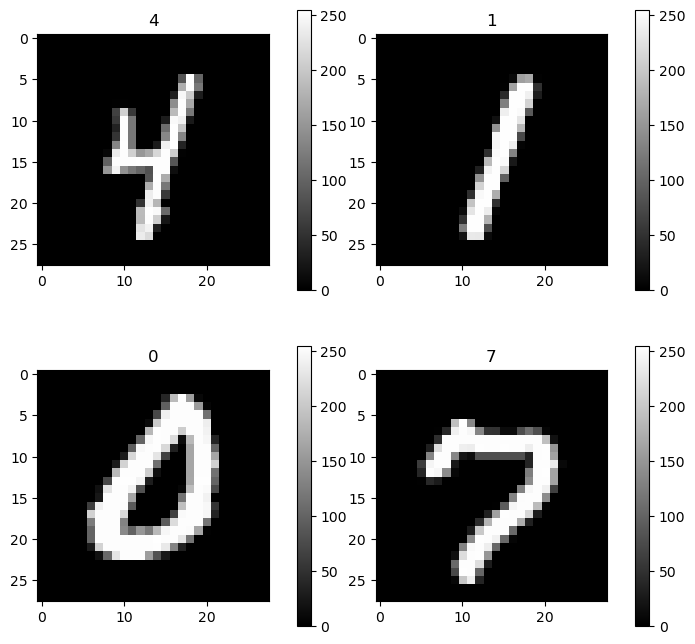

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i, example in enumerate(mnist_dset.take(4)): # We take only 4 examples from the dataset 
    im = ax[i].imshow(example['image'][:,:,0],cmap='gray')
    ax[i].set_title("%d"%example['label'])
    plt.colorbar(im, ax=ax[i], pad=0.1, fraction=0.08)


For our purpose of generative modeling, we only need to grab the image, we don't care about the label, and we are going to preprocess these images as floats and rescale them between 0 and 1 (compared to the standard 0-255 ranges of the gray scale). This can all be done by a preprocessing function:

In [5]:
def normalize_img(example):
    """ Preprocessing function that rescales an image between 0,1
    This pre-processing function will return twice the image because for an 
    autoencoder the target is the same as the input (non supervised learning).
    """
    im = tf.cast(example['image'], tf.float32) / 255.
    return im, im

We can now create a full input pipeline for our 
dataset using this pre-processing function.

In [6]:
batch_size = 128

dataset = mnist_dset.map(normalize_img)    # Apply the pre-processing function
n_examples = dataset.cardinality().numpy()
dataset = dataset.shuffle(10000)           # Shuffle the data over a given buffer 
dataset = dataset.batch(batch_size)        # Batch the data
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) # Pre-fetch the data in parallel

# check how many steps we have in each epoch
batch_per_epoch = dataset.cardinality().numpy()
print(f'With a batch size of {batch_size}, and {n_examples} images, we have {batch_per_epoch} batches per epoch')

With a batch size of 128, and 60000 images, we have 469 batches per epoch


To learn more about how to use the `tf.data.Datasets` API, check out (https://www.tensorflow.org/guide/data).

## Building a Keras Auto-Encoder


Now that we have access to some data, our first goal will be to create a Convolutional Auto-Encoder, which can compress images (in our case of size 28x28) down to some low dimensional latent representation (for instance 2).

### Encoder

We begin with the encoder.

We first chose the dimension of the latent space, i.e. to how many dimension we compress our input images. Here we set it to two to be able to visualise it:

In [7]:
LS_dim = 2

The Encoder is just two convolutional layers, and then one dense layer to output the 2 dimensions of the latent space:

In [8]:
X_in = tfk.Input(shape=(28, 28, 1), name='Encoder_Input')
y = tf.keras.layers.Conv2D(8, kernel_size=3, activation='relu', strides=2, padding='same', name='E_conv1')(X_in)
y = tfkl.Conv2D(16, kernel_size=3, activation='relu', strides=2, padding='same', name='E_conv2')(y)
y = tfkl.Flatten(name='Flattening')(y)
code = tfkl.Dense(LS_dim, name='Code_Prediction')(y)
Encoder = tfk.Model(X_in, code, name='Encoder')

In [9]:
Encoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder_Input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 E_conv1 (Conv2D)            (None, 14, 14, 8)         80        
                                                                 
 E_conv2 (Conv2D)            (None, 7, 7, 16)          1168      
                                                                 
 Flattening (Flatten)        (None, 784)               0         
                                                                 
 Code_Prediction (Dense)     (None, 2)                 1570      
                                                                 
Total params: 2,818
Trainable params: 2,818
Non-trainable params: 0
_________________________________________________________________


Predicting the number of total trainable parameters is a very good exercise, here some homework !
(Answer hidden at the end of the notebook)

In [10]:
tfk.utils.plot_model(Encoder, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.



### Decoder

The next step is to build an decoder that mirrors the encoder and transforms a vector of low dimensionality back to an image. Here we use an operation called Transposed Convolution.
The math behind it are a bit peculiar, but you can see it as the opposite of the strided convolution: it will do a convolution that "stretch" your image.
You can also use a simpler technique, which is simply doing a non strided convolution (output is the same shape  as the input) and then copy the pixels to stretch the image.

In [11]:
decoder_input = tfk.Input(shape=(LS_dim,), name='Decoder_Input')
y = tfkl.Dense(7*7*16, activation='relu', name='Decoder_Dense')(decoder_input) # see the graph above, we want to match the ast shape before the code
y = tfkl.Reshape((7, 7, 16), name='Reshape_to_2D')(y)
y = tfkl.Conv2DTranspose(32, kernel_size=3, activation='relu', strides=2, padding='same', name='D_conv1')(y)
y = tfkl.Conv2DTranspose(16, kernel_size=3, activation='relu', strides=2, padding='same', name='D_conv2')(y)
reconstructed_img = tfkl.Conv2DTranspose(1, kernel_size=3, activation='sigmoid', strides=1, padding='same', name='D_conv2image')(y)
Decoder = tfk.Model(decoder_input, reconstructed_img, name='Decoder')

In [12]:
Decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Decoder_Input (InputLayer)  [(None, 2)]               0         
                                                                 
 Decoder_Dense (Dense)       (None, 784)               2352      
                                                                 
 Reshape_to_2D (Reshape)     (None, 7, 7, 16)          0         
                                                                 
 D_conv1 (Conv2DTranspose)   (None, 14, 14, 32)        4640      
                                                                 
 D_conv2 (Conv2DTranspose)   (None, 28, 28, 16)        4624      
                                                                 
 D_conv2image (Conv2DTranspo  (None, 28, 28, 1)        145       
 se)                                                             
                                                           

In [13]:
tfk.utils.plot_model(Decoder, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Combine the two models
Now we can create a global model that combine the encoder and decoder. Note that you could just have created a big model. But this is more practical, because if then you just want to use the encoder to explore the latent space or only the decoder to generate new images, you can, which can save you lots of time if your model gets bigger.

In [14]:
AE_inputs = tfk.Input(shape=(28, 28, 1), name='AE_input')
code = Encoder(AE_inputs)
gen_img = Decoder(code)
AE = tfk.Model(AE_inputs, [gen_img, code], name='Auto Encoder')


In [15]:
AE.summary()

Model: "Auto Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 AE_input (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 Encoder (Functional)        (None, 2)                 2818      
                                                                 
 Decoder (Functional)        (None, 28, 28, 1)         11761     
                                                                 
Total params: 14,579
Trainable params: 14,579
Non-trainable params: 0
_________________________________________________________________


In [16]:
tfk.utils.plot_model(AE, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


And just for fun, we can try to see how the reconstructed images look like with the untained model:


In [17]:
for batch_imgs, _ in dataset.take(1):    
    generated_img = AE(batch_imgs)[0]

2024-09-13 11:17:57.840468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2024-09-13 11:17:57.840723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2024-09-13 11:17:58.001533: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline s

Text(0.5, 1.0, 'Reconstructed Images')

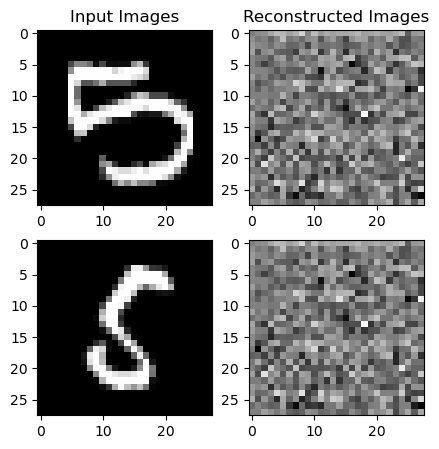

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(5, 5))
for i in range(2):
    ax[i, 0].imshow(batch_imgs.numpy()[i], cmap='gray')
    ax[i, 1].imshow(generated_img.numpy()[0], cmap='gray')
ax[0, 0].set_title('Input Images')
ax[0, 1].set_title('Reconstructed Images')

Unsurprisingly, we get a bunch of garbage! Let's try to do some training and see what happens after that.

## Training the Auto-Encoder
### Simple way:

``` python
auto_encoder.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=tf.keras.losses.binary_crossentropy)
history = auto_encoder.fit(dset, epochs=10)  # Starts training both encoder and decoder


### Custom way
Again, we can use the fit fucntion of keras, but I prefer cerating my own trainig loop, which allows mnore flexibility:

In [19]:
def train_model(X, loss_fn, optimizer):
    """ with this, tf will automatically record al the info to then compute all gradients and then more the weights with gradient descent """
    with tf.GradientTape() as tape:
        ##### reconstruct the image by passing the image trhought eh whole AE ######
        pred = AE(X)[0]  
        ##### Compute the loss between the reconstructed image and the input image ######
        loss = loss_fn(X, pred)
    
    ##### Compute the gradients of the loss regarding the weights #####
    gradients = tape.gradient(loss, AE.trainable_variables)
    ##### Apply the gradients to update the weights #####

    optimizer.apply_gradients(zip(gradients, AE.trainable_variables))
    return (np.mean(loss.numpy()))  # mean because the loss is computed individually for each instance of the current batch

loss_fn = tfk.losses.MSE # simple mean square error between each x and y
optimizer = tfk.optimizers.Adam(learning_rate=5e-3)  # the simple stochastic gradient descent algorithm

## We are now ready to train !
Let s do it for 5 epochs (that is already wuite a lot of steps), and we save the loss every step

In [20]:
losses = []
nb_epochs = 5

for epoch in range(nb_epochs):
    print(f'Epoch {epoch}')
    for i, (batch, _) in enumerate(dataset):
        if i % 200 == 0:
            print(f'{i}th batch over {batch_per_epoch}')
        results = train_model(batch, loss_fn, optimizer)
        losses.append(results)

2024-09-13 11:17:58.140751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2024-09-13 11:17:58.141091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


Epoch 0
0th batch over 469
200th batch over 469
400th batch over 469
Epoch 1
0th batch over 469
200th batch over 469
400th batch over 469
Epoch 2
0th batch over 469
200th batch over 469
400th batch over 469
Epoch 3
0th batch over 469
200th batch over 469
400th batch over 469
Epoch 4
0th batch over 469
200th batch over 469
400th batch over 469


And that's it, our model should more or less be trained by now. We can check the model history to see what the loss function looks like as a function of training epochs:

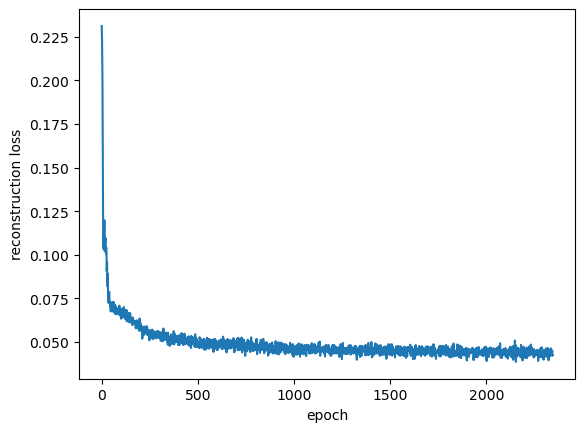

In [21]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('reconstruction loss');

Note that we didnt do validation ! It s bad !!

Now, we can apply the model on a batch of images and see what comes out:

In [22]:
decoded_images, codes = AE(batch_imgs)

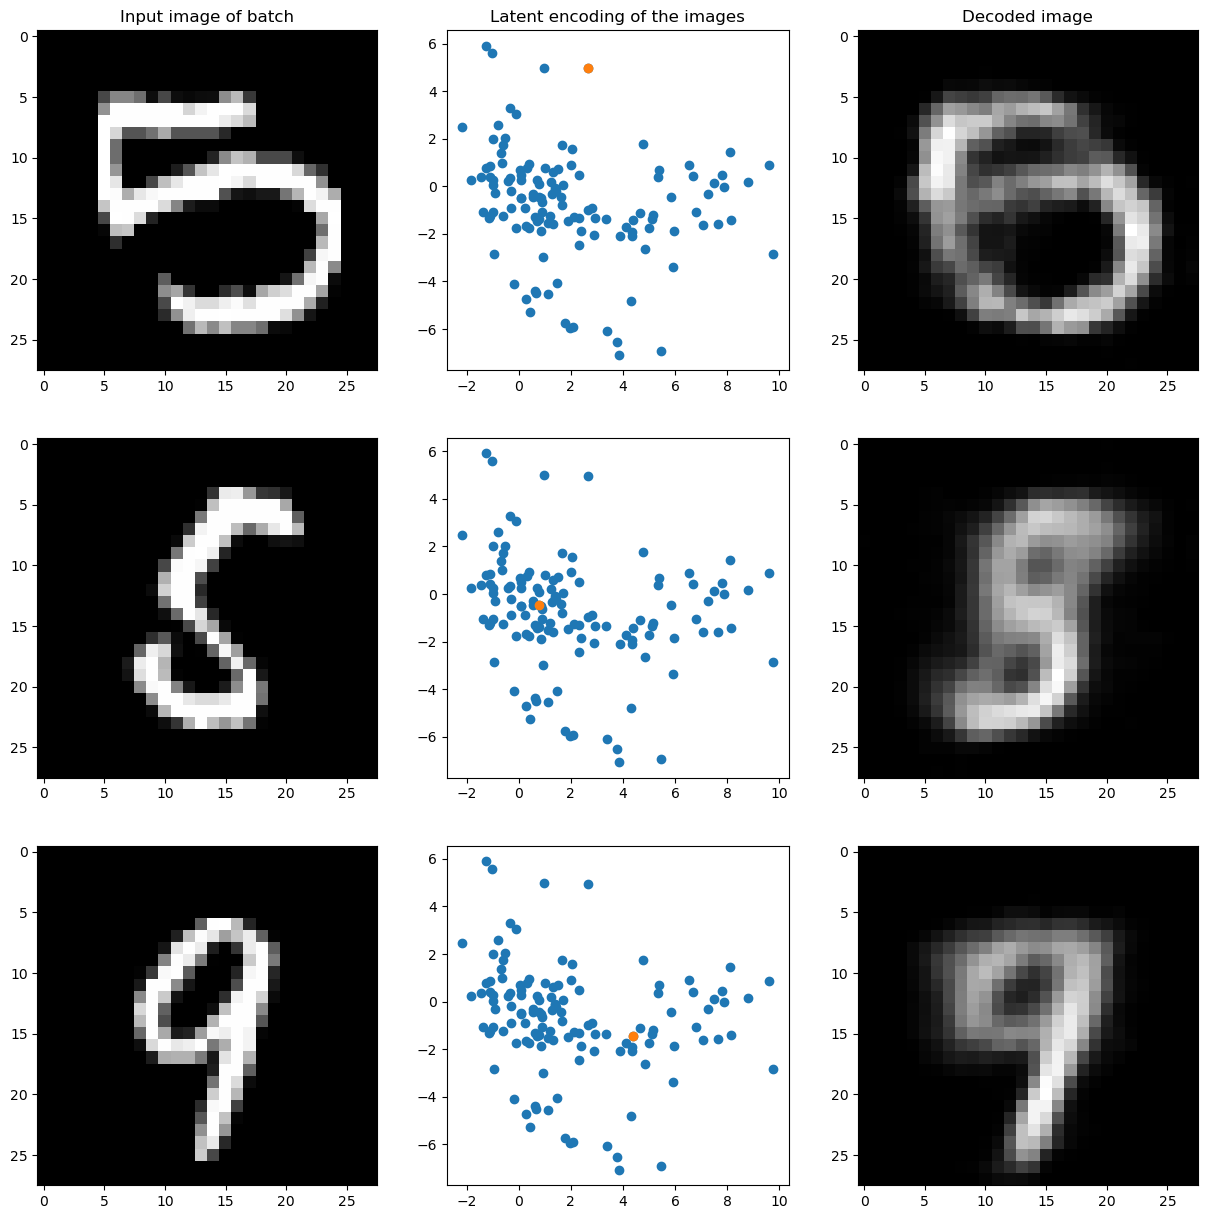

In [23]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax[0, 0].set_title('Input image of batch')
ax[0, 1].set_title('Latent encoding of the images')
ax[0, 2].set_title('Decoded image')
for i in range(3):
    ax[i, 0].imshow(batch_imgs[i, :, :, 0],cmap='gray')
    ax[i, 1].scatter(codes[:, 0], codes[:, 1])
    ax[i, 1].scatter(codes[i, 0], codes[i, 1])
    ax[i, 2].imshow(decoded_images[i, :, :, 0],cmap='gray')


## Testing

Now let see if our model is robust on unseen images, and let's better visualize the latent space, and try ot generate new images !

Let's prepare the test dataset:

In [24]:
mnist_test_dset = tfdatasets.load(name="mnist",
                            split='test')

def normalize_img_test(example):
    """ Normalize images, like during training, but also returns label
    """
    im = tf.cast(example['image'], tf.float32) / 255.
    return im, example['label']

# We build a simplified pipeline for testing
dset_test = mnist_test_dset.map(normalize_img_test)
dset_test = dset_test.batch(1024) # We use a large batch of 1024 examples

We predict the codes and the reconstructed images:

In [25]:
for batch, labels in dset_test.take(1):
    batch_imgs = batch
    codes = Encoder(batch)
    decoded_images = Decoder(codes)

2024-09-13 11:18:50.076426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2024-09-13 11:18:50.076657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2024-09-13 11:18:50.106589: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline si

We can do the same plot as above but for the test set:

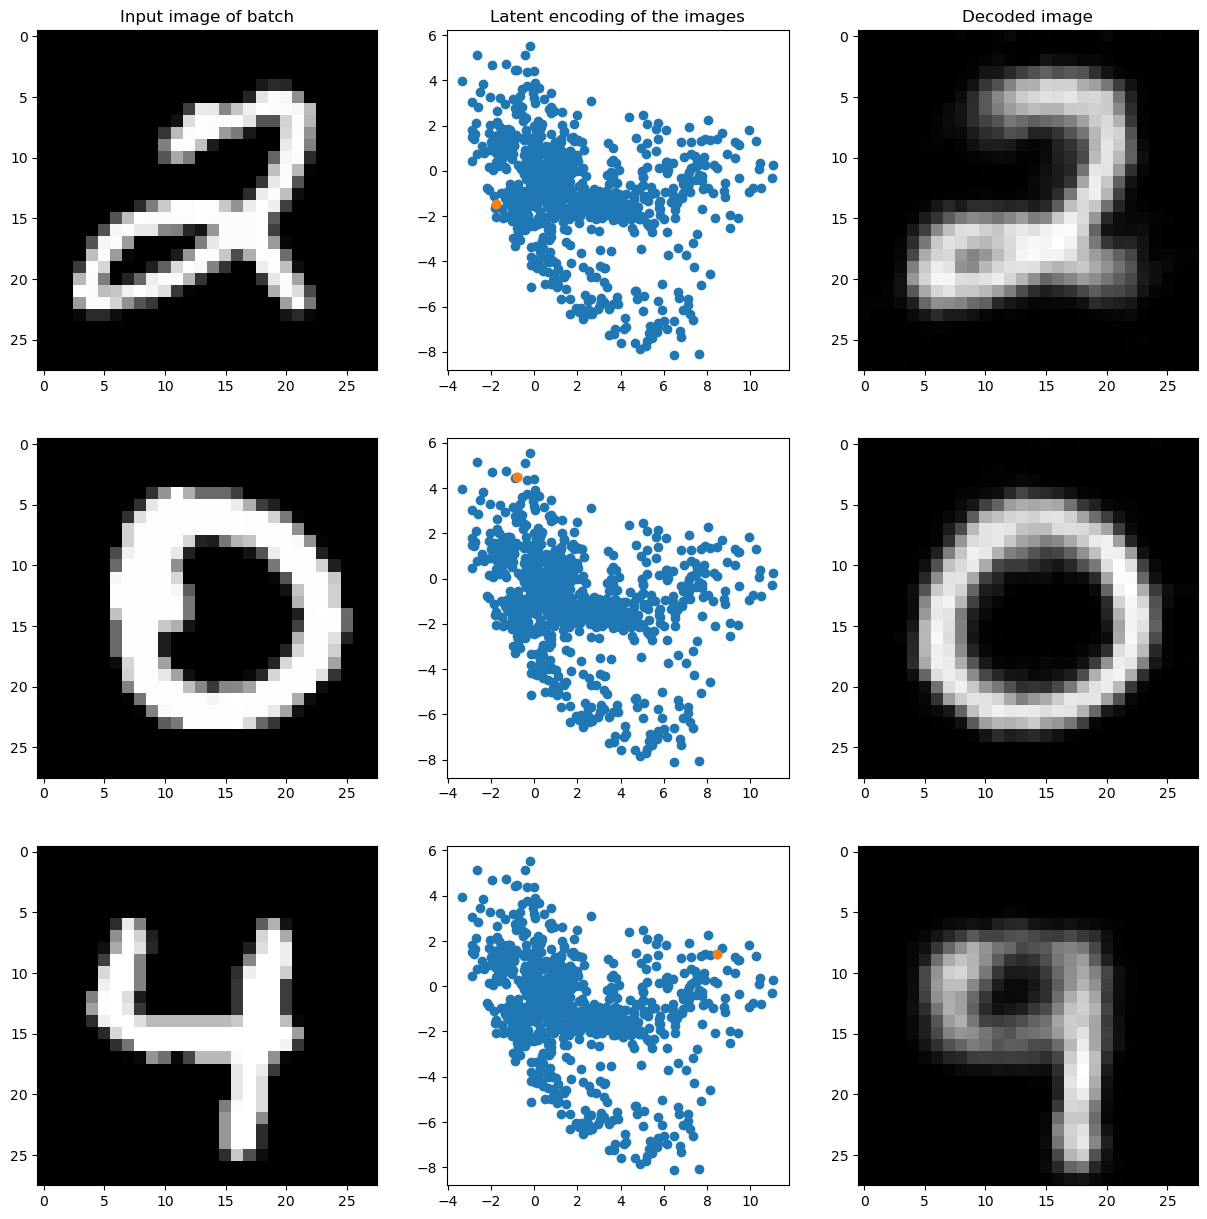

In [26]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax[0, 0].set_title('Input image of batch')
ax[0, 1].set_title('Latent encoding of the images')
ax[0, 2].set_title('Decoded image')
for i in range(3):
    ax[i, 0].imshow(batch_imgs[i, :, :, 0],cmap='gray')
    ax[i, 1].scatter(codes[:, 0], codes[:, 1])
    ax[i, 1].scatter(codes[i, 0], codes[i, 1])
    ax[i, 2].imshow(decoded_images[i, :, :, 0],cmap='gray')


#### Visualizing the latent space

We can now have a look at how different digits are encoded in the latent space, for one batch of 1024 images.

We are color coding the points with their true label, to see if they are some interesting organisation in the latent space

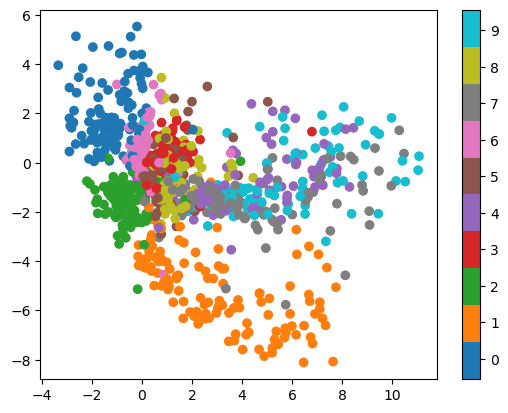

In [27]:
plt.scatter(codes[:, 0], codes[:, 1], c=labels, cmap='tab10');
cbar = plt.colorbar()
cbar.set_ticks(np.linspace(0.5, 8.5, 10))
cbar.set_ticklabels(np.linspace(0, 9, 10).astype('int'))

This is super interesting ! It looks like the latent space is naturally organised, with images looking similar (same numbers) are encoded to a similar code ! 
We can use this to generate new numbers, but we could also do some classification with clustering or oterh stuff ! imagine this natural organisation of similar obejcts but with more complex data. The power of this code is huge !

## Interactive Visualization

We are now going to do an interactive visualization showing the power of our AE.

Don't look to much to the code (if you want tutorial about that, you can check my github)

The plot is going to be clickable, and you have on the left the latent space with the 1024 encoded images. You can click on it ! it will create a code at the position you clicked,
feed it to the decoder, and show the generated images. You are now generating new 'invented' hand-written digits !


In [28]:
# ```python
class Explore_ls:
    def __init__(
        self, 
        fig, 
        ax, 
        codes
    ):

        self.plot_ls = ax[0]  # define the left subplot, where the latent space is plotted
        self.new_samples = [] 
        self.image = ax[1]     # define the right subplot, where the image is created
        self.codes = codes
        fig.canvas.mpl_connect('button_press_event', self)

        # plot the latent space
        self.ls_plot = self.plot_ls.scatter(codes[:, 0],codes[:, 1],c=labels, cmap='tab10')
        self.plot_ls.set_xlabel('z1')
        self.plot_ls.set_ylabel('z2')

        # Reserve some space on top for the title
        fig.subplots_adjust(top=0.8)

    def __call__(self, event):

        click_x = event.xdata
        click_y = event.ydata
        self.plot_ls.set_title(click_x)
        if event.button == 1:
        
            # Create and plot the sample in the LS
            self.new_samples.append(self.plot_ls.scatter(
                event.xdata, 
                event.ydata, 
                marker='*',  # change the marker style to distinguish between sample from the encoded digits
                c='red',     # and the new samples
            ))
            
            # Add info to the title
            self.plot_ls.set_title(f"clicked (z0, z1): ({click_x:.2f}, {click_y:.2f})")
            
            #sample the vector to feed the decoder
            sample = np.reshape([click_x, click_y], (1, 2))
            # feed and run the decoder
            decoded = Decoder(sample)
            # Show the decoded image
            self.image.imshow(decoded[0, :, :, 0], cmap='gray')



In [29]:
%matplotlib widget

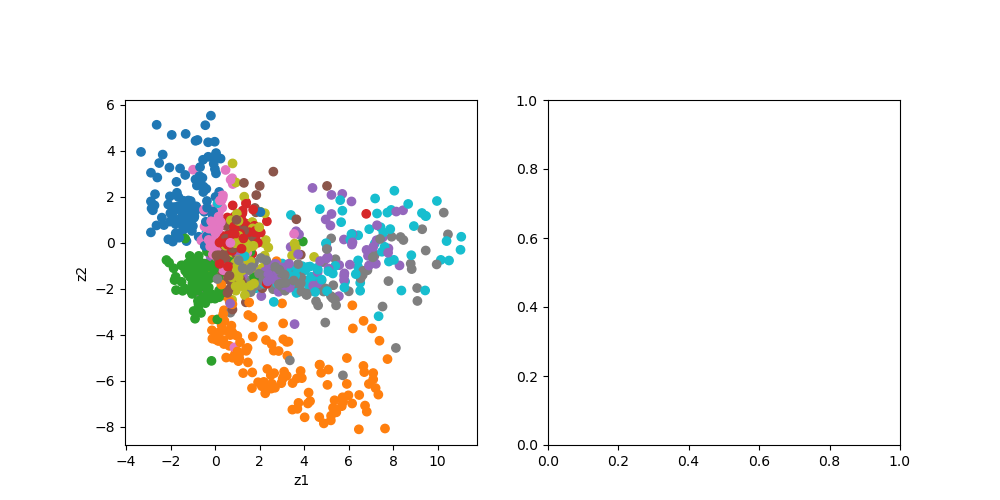

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
interact = Explore_ls(fig, ax, codes)


### Encoer Weights number computation answer:


In [31]:
Encoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder_Input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 E_conv1 (Conv2D)            (None, 14, 14, 8)         80        
                                                                 
 E_conv2 (Conv2D)            (None, 7, 7, 16)          1168      
                                                                 
 Flattening (Flatten)        (None, 784)               0         
                                                                 
 Code_Prediction (Dense)     (None, 2)                 1570      
                                                                 
Total params: 2,818
Trainable params: 2,818
Non-trainable params: 0
_________________________________________________________________



- First layer: 1 input feature, 8 kernels of 3 by 3 weights, and 8 biases (one per kernel): $1\times8\times(3\times3) + 8 = 80$ 
- Second layer: 8 input features, 16 kernels per input featuresof 3 by 3 weights, and 16 biases (one per kernel): $8\times16\times(3\times3) + 16 = 1168$
- Third layer: 784 input features ($7\times7\times16$), 2 neurons: $784\times2 + 2 = 1570$
- Do the sum: 2818: tadaaaaam